In [25]:
import imp
import pandas as pd
import numpy as np
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import math
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

%matplotlib inline


In [31]:
# Startegy
initial_cap = 1000000


class PairsTradingStrategy(bt.Strategy):
    def __init__(self):
        self.pending_orders = dict()

    def notify_order(self, order):
        if not order is None:
            if order.status == order.Completed:
                symbol = self.pending_orders[order.ref]
                print("%s: %s order filled" % (self.datetime.datetime(), symbol))

    #! this line of code is part of solution described above
    def prenext(self):
        self.next()

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        # past 1d regression

        if self.datetime.datetime() < (self.datas[0]._dataname.index[0] + pd.Timedelta(1, "d")):
            return
        close1 = (
            self.datas[0]._dataname["close"].loc[self.datetime.date() - pd.Timedelta(1, "d") : self.datetime.datetime()]
        )
        close2 = (
            self.datas[1]._dataname["close"].loc[self.datetime.date() - pd.Timedelta(1, "d") : self.datetime.datetime()]
        )
        assert len(close1) == len(close2)
        if len(close1) == 0:
            return
        lr = LinearRegression().fit(close1.values.reshape(-1, 1), close2.values.reshape(-1, 1))
        residual = close2.values.reshape(-1, 1) - lr.predict(close1.values.reshape(-1, 1))
        # normalize residual
        residual = (residual - np.mean(residual)) / np.std(residual)

        for i, d in enumerate(self.datas):
            #! this line of code is part of solution described above
            #! check if instrument is available for trading

            can_trade = self.datetime.datetime() in self.datas[i]._dataname.index
            no_position = not self.getposition(self.datas[i])

            if can_trade:
                sign = 1 if i == 0 else -1
                if residual[-1] > 3:
                    order = self.order_target_value(data=self.datas[0], target=sign * initial_cap * 0.2)
                    if not order is None:
                        self.pending_orders[order.ref] = d._name
                elif residual[-1] < -3:
                    order = self.order_target_value(data=self.datas[0], target=-sign * initial_cap * 0.2)
                    if not order is None:
                        self.pending_orders[order.ref] = d._name
                elif residual[-1] > -1 and residual[-1] < 1:
                    order = self.order_target_value(data=self.datas[0], target=0)
                    if not order is None:
                        self.pending_orders[order.ref] = d._name

                    print("%s: %s order submitted" % (self.datetime.datetime(), d._name))


In [32]:
# Initialize backtesting
cerebro = bt.Cerebro(stdstats=False)
sushi_usdc = pd.read_csv("sushi_usdc.csv", index_col=0, parse_dates=True)
cerebro.adddata(bt.feeds.PandasData(dataname=sushi_usdc, openinterest=-1), name="sushi")
eth_usdc = pd.read_csv("eth_usdc.csv", index_col=0, parse_dates=True)
cerebro.adddata(bt.feeds.PandasData(dataname=eth_usdc, openinterest=-1), name="eth")
cerebro.broker.setcash(10000 * 2)
cerebro.addstrategy(PairsTradingStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

strats = cerebro.run()


2020-09-10 19:00:00: sushi order submitted
2020-09-10 19:00:00: eth order submitted
2020-09-10 20:00:00: sushi order submitted
2020-09-10 20:00:00: eth order submitted
2020-09-10 21:00:00: sushi order submitted
2020-09-10 21:00:00: eth order submitted
2020-09-10 22:00:00: sushi order submitted
2020-09-10 22:00:00: eth order submitted
2020-09-10 23:00:00: sushi order submitted
2020-09-10 23:00:00: eth order submitted
2020-09-11 00:00:00: sushi order submitted
2020-09-11 00:00:00: eth order submitted
2020-09-11 01:00:00: sushi order submitted
2020-09-11 01:00:00: eth order submitted
2020-09-11 02:00:00: sushi order submitted
2020-09-11 02:00:00: eth order submitted
2020-09-11 05:00:00: sushi order submitted
2020-09-11 05:00:00: eth order submitted
2020-09-11 06:00:00: sushi order submitted
2020-09-11 06:00:00: eth order submitted
2020-09-11 07:00:00: sushi order submitted
2020-09-11 07:00:00: eth order submitted
2020-09-11 08:00:00: sushi order submitted
2020-09-11 08:00:00: eth order su

c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\pyfolio\utils.py:299: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  '=False to disable.')
c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\pyfolio\utils.py:352: FutureWarning: 'date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  txn_val = txn_val.groupby('date').cumsum()
c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\pyfolio\utils.py:357: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  pd.TimeGrouper('24H'))['exposure'].transform(max))
c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\empyrical\stats.py:1492: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2020-09-09
End date,2022-08-20
Total months,33
,Backtest
Annual return,66.5%
Cumulative returns,321.1%
Annual volatility,1247.8%
Sharpe ratio,0.42
Calmar ratio,0.17
Stability,NaN
Max drawdown,-380.9%


c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,380.86,2020-12-03,2021-05-14,NaT,NaN
1,53.37,2020-09-11,2020-09-12,2020-09-15,3
2,34.53,2020-09-25,2020-10-02,2020-11-04,29
3,23.09,2020-11-04,2020-11-17,2020-11-18,11
4,10.86,2020-09-15,2020-09-16,2020-09-17,3


Stress Events,mean,min,max
New Normal,2.09%,-622.21%,1550.01%


Top 10 long positions of all time,max
sid,
sushi,99.20%


Top 10 short positions of all time,max
sid,
sushi,-11027.78%


Top 10 positions of all time,max
sid,
sushi,11027.78%
eth,0.00%


c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\pyfolio\round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
c:\Users\DESKTOP\anaco

Summary stats,All trades,Short trades
Total number of round_trips,88.00,88.00
Percent profitable,0.50,0.50
Winning round_trips,44.00,44.00
Losing round_trips,44.00,44.00
Even round_trips,0.00,0.00


PnL stats,All trades,Short trades
Total profit,$64212.95,$64212.95
Gross profit,$555121.31,$555121.31
Gross loss,$-490908.36,$-490908.36
Profit factor,$1.13,$1.13
Avg. trade net profit,$729.69,$729.69
Avg. winning trade,$12616.39,$12616.39
Avg. losing trade,$-11157.01,$-11157.01
Ratio Avg. Win:Avg. Loss,$1.13,$1.13
Largest winning trade,$87418.42,$87418.42
Largest losing trade,$-84177.24,$-84177.24


Duration stats,All trades,Short trades
Avg duration,2 days 15:30:00,2 days 15:30:00
Median duration,0 days 08:00:00,0 days 08:00:00
Longest duration,67 days 11:00:00,67 days 11:00:00
Shortest duration,0 days 01:00:00,0 days 01:00:00


Return stats,All trades,Short trades
Avg returns all round_trips,62.65%,62.65%
Avg returns winning,133.80%,133.80%
Avg returns losing,-8.49%,-8.49%
Median returns all round_trips,0.02%,0.02%
Median returns winning,10.14%,10.14%
Median returns losing,-4.72%,-4.72%
Largest winning trade,1798.77%,1798.77%
Largest losing trade,-53.45%,-53.45%


Symbol stats,sushi
Avg returns all round_trips,62.65%
Avg returns winning,133.80%
Avg returns losing,-8.49%
Median returns all round_trips,0.02%
Median returns winning,10.14%
Median returns losing,-4.72%
Largest winning trade,1798.77%
Largest losing trade,-53.45%


Profitability (PnL / PnL total) per name,
symbol,
sushi,100.00%


c:\Users\DESKTOP\anaconda3\envs\py36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


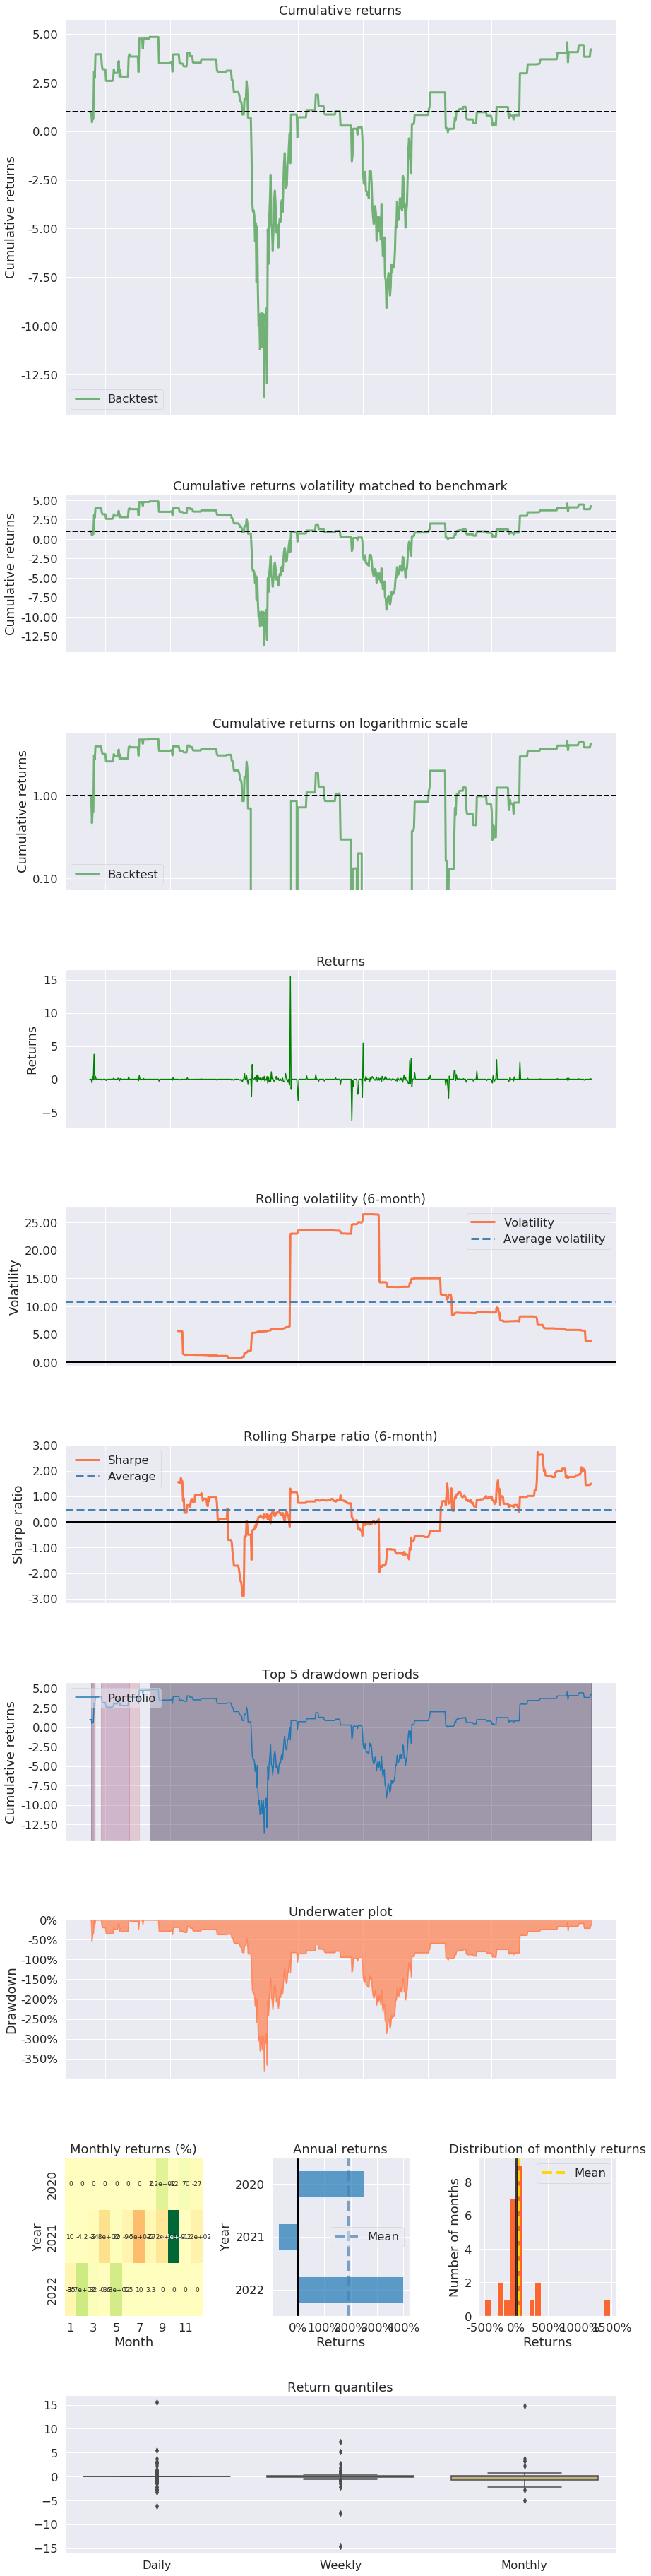

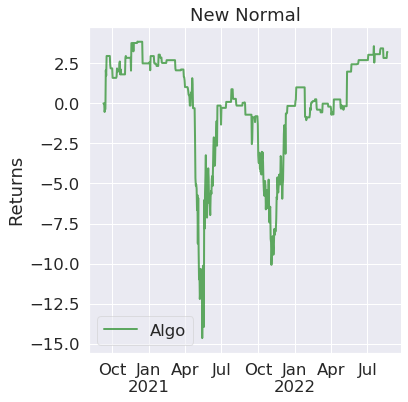

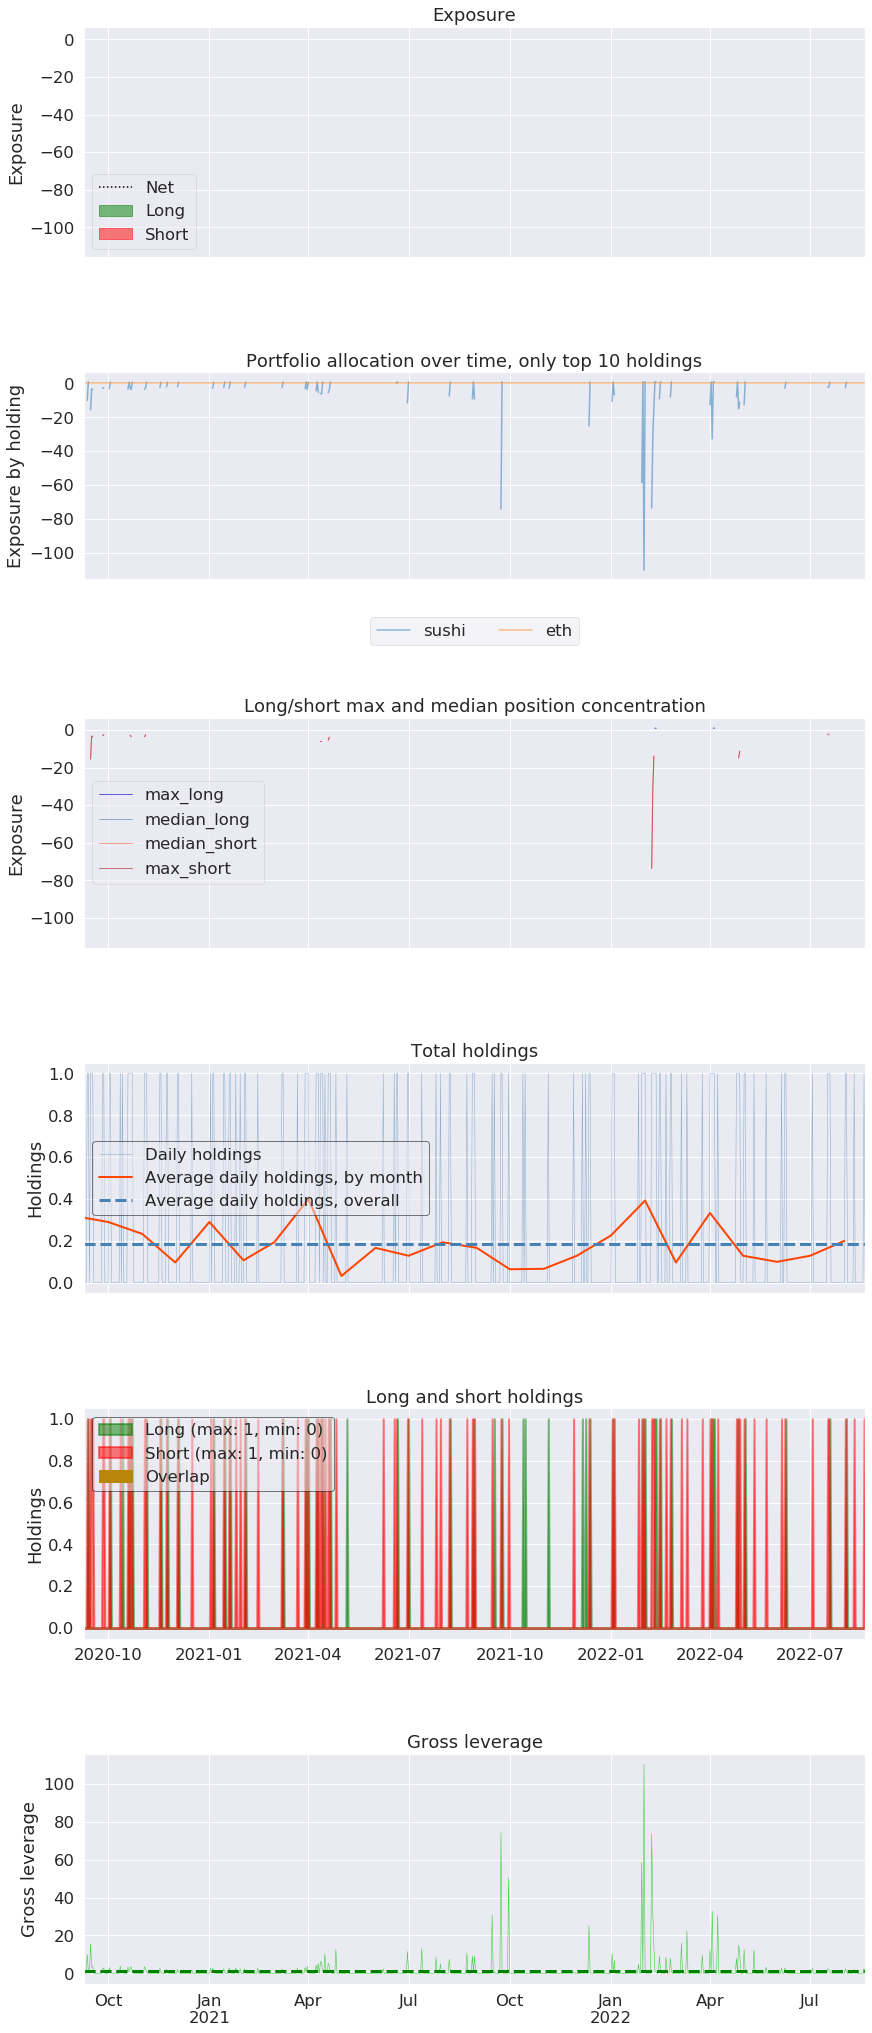

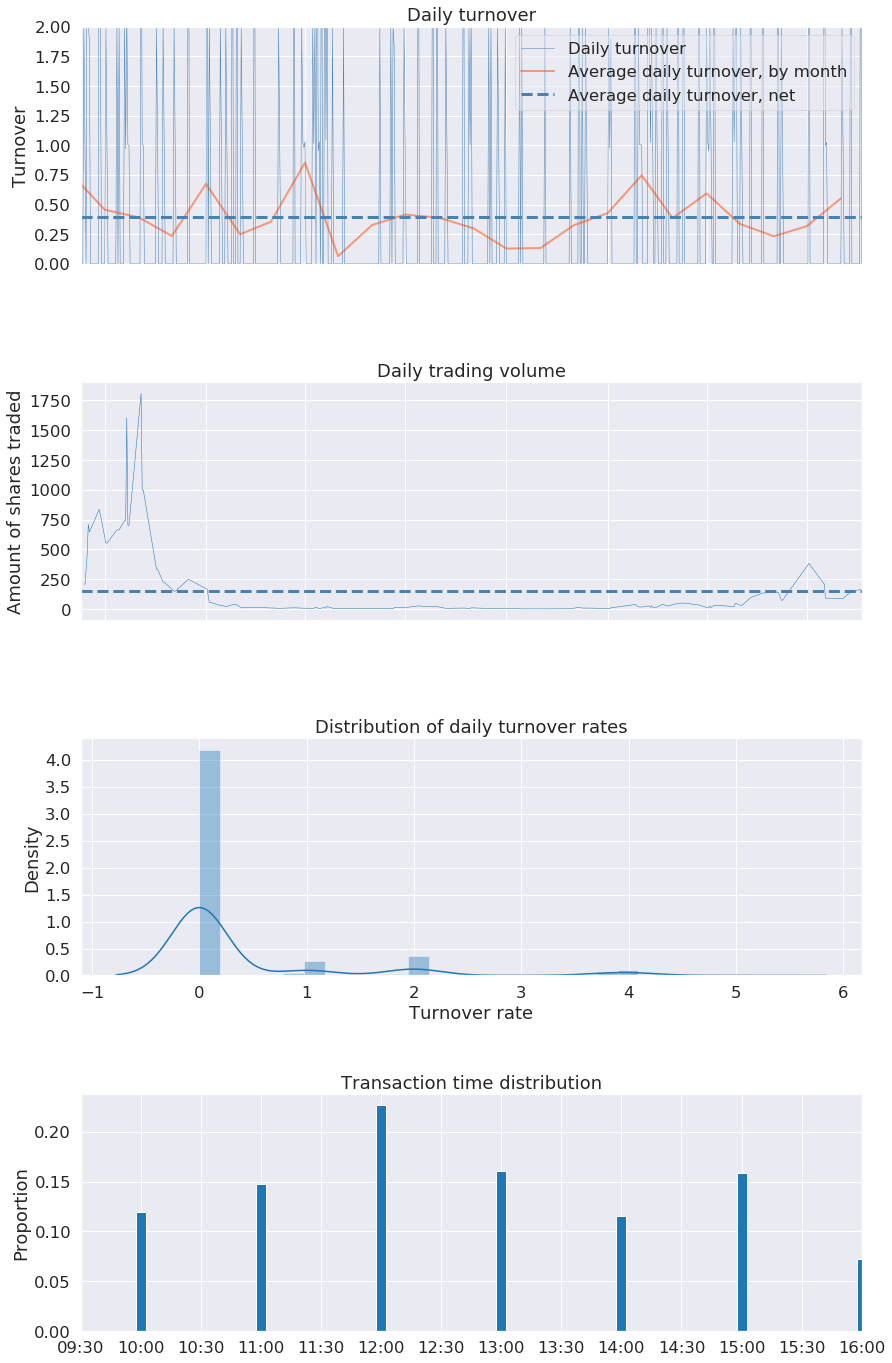

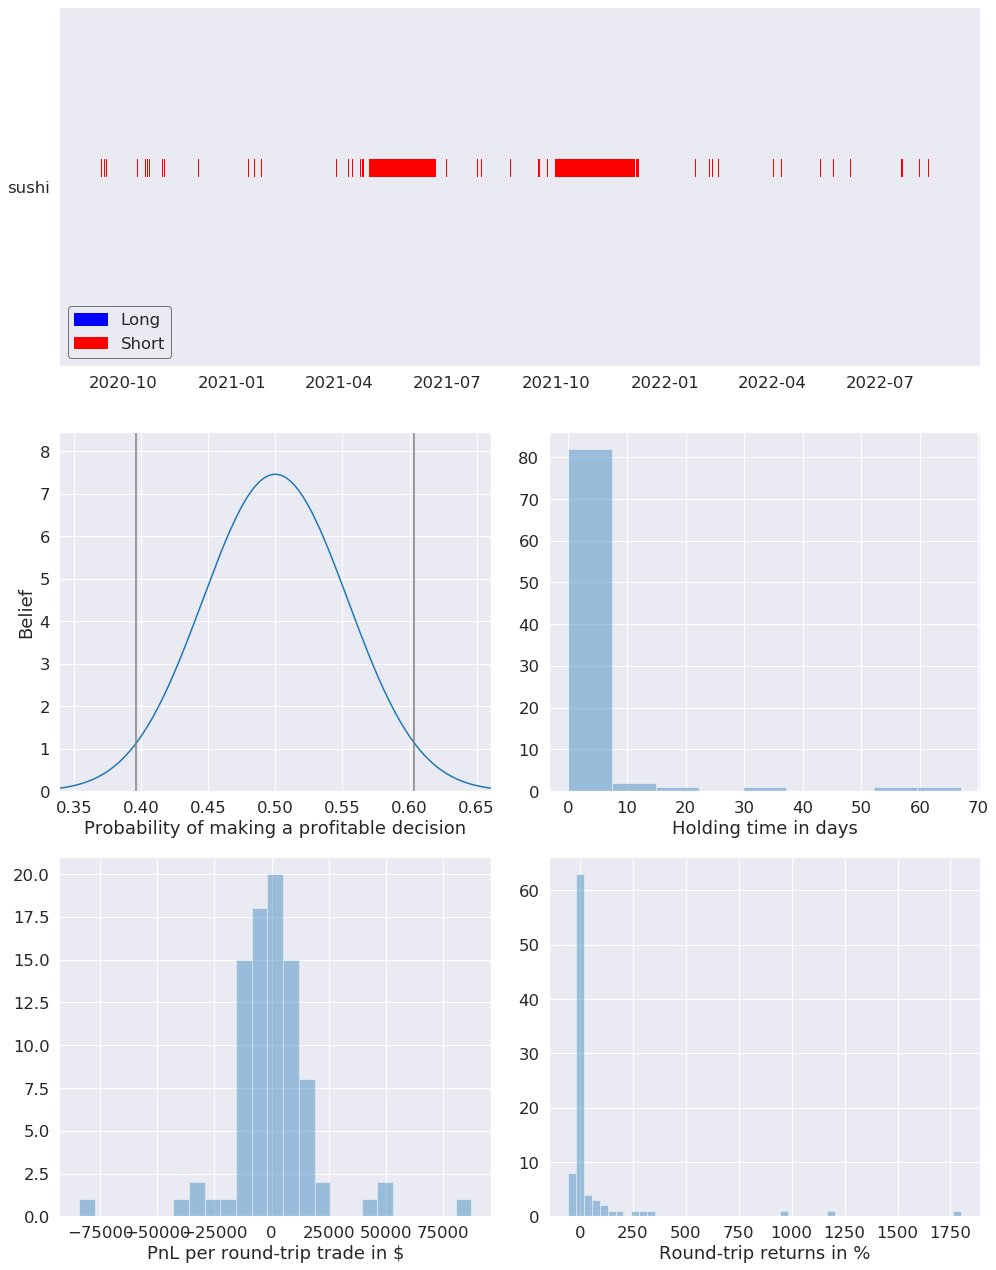

In [33]:
import pyfolio as pf
%matplotlib inline
pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # live_start_date='2005-05-01',  # This date is sample specific
    round_trips=True)
